Importing needed libraries

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

Defining hyperparameters

In [2]:
# number_of_nodes specifies number of nodes in the network. 
number_of_nodes = 10

# Traditional NN layer dimensions. First value should be equal to input dimensions. 
input_dim= 28*28
layers_dims = [input_dim, 200,  10]
len_layers= len(layers_dims)
learning_rate = 0.1
epoch = 1000

Defining NN model. Traditional MLP network. Layer size and number of neurons in layer can be specified with layer_dim array. Additionally, parameters can be get and set. 

In [3]:
class NN:
    def __init__(self, layers_size):

        # layer_size parameter defines MLP dimensions. For example if layer_size [784, 50, 50, 10] then 
        # network has 3 layer and input dimension should be match with first value of array.
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)-1
        self.n = 0
        self.costs = []
        self.initialize_parameters()

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def initialize_parameters(self):
        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(
                self.layers_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))

    def forward(self, X):
        store = {}

        A = X.T
        
        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A) + \
                self.parameters["b" + str(l + 1)]
            A = self.sigmoid(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z

        Z = self.parameters["W" + str(self.L)].dot(A) + \
            self.parameters["b" + str(self.L)]
        A = self.softmax(Z)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z

        return A, store
    
    def sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)

    def backward(self, X, Y, store):

        derivatives = {}

        store["A0"] = X.T

        A = store["A" + str(self.L)]
        dZ = A - Y.T

        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
        db = np.sum(dZ, axis=1, keepdims=True) / self.n
        dAPrev = store["W" + str(self.L)].T.dot(dZ)

        derivatives["dW" + str(self.L)] = dW
        derivatives["db" + str(self.L)] = db

        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
            db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = store["W" + str(l)].T.dot(dZ)

            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db

        return derivatives

    def get_all_parameters(self, name):
        return self.parameters[name]

    def get_parameter(self, name):
        return self.parameters[name]

    def set_parameter(self, name, value):
        self.parameters[name] = value
    
    def fit(self, X, Y, learning_rate=0.01, n_iterations=2500, model_name=""):
        np.random.seed(1)

        self.n = X.shape[0]

        for loop in range(n_iterations):
            A, store = self.forward(X)

            cost = -np.mean(Y * np.log(A.T + 1e-8))

            derivatives = self.backward(X, Y, store)

            for l in range(1, self.L + 1):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
                    "dW" + str(l)]
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
                    "db" + str(l)]

            if loop % 100 == 0:
                acc = self.predict(X, Y)
                if model_name is not "":
                    print("Epoch: ", int(n_iterations/100), " / ",
                          int(loop/100), " --- Model:", model_name)
                else:
                    print("Epoch: ", int(n_iterations/100), " / ", int(loop/100))

                print("Model: ", model_name, " Cost: ",
                      cost, "Train Accuracy:", acc)

            if loop % 10 == 0:
                self.costs.append(cost)
    
    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100

    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()

Methods used in federated learning process

3 methods are used for distrubuting dataset over nodes independent and identically. First method, shuffle labels and their indexes accordingly. Second method distrubutes this label sets to nodes and at the last method also images are get and store set and label in dictionary

In [4]:
# Method shuffles labels at the beginning and store their indexes separately
def split_and_shuffle_labels(y_data, seed, amount):
    y_data = pd.DataFrame(y_data)
    y_data["i"] = np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name = "label" + str(i)
        label_info = y_data[y_data["class"] == str(i)]
        np.random.seed(seed)
        label_info = np.random.permutation(label_info)
        label_info = label_info[0:amount]
        label_info = pd.DataFrame(label_info, columns=["labels", "i"])
        label_dict.update({var_name: label_info})
    return label_dict

# The ındexes that grouped previous method are distributed to node datasets equally
def get_iid_subsamples_indices(label_dict, number_of_nodes, amount):
    sample_dict = dict()

    for i in range(number_of_nodes):
        sample_name = "node"+str(i)
        dumb = pd.DataFrame()
        for j in range(10):
            label_name = str("label")+str(j)
            total = len(label_dict[label_name])
            batch_size = int(total/number_of_nodes)
            a = label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb = pd.concat([dumb, a], axis=0)
        dumb.reset_index(drop=True, inplace=True)
        sample_dict.update({sample_name: dumb})
    return sample_dict

# Creating datasets for each node according to the indexes getting at previous method. 
# Images at the related index and labels are transformed to dataset.
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict = dict()
    y_data_dict = dict()


    for i in range(len(sample_dict)): 
        xname = x_name+str(i)
        yname = y_name+str(i)
        node_name = "node"+str(i)


        indices = np.sort(
            np.array(sample_dict[node_name]["i"], dtype=np.int32))

        x_info = np.asfarray(x_data)[indices, :]
        y_info = np.asfarray(y_data)[indices]

        # Preprocessing before going to be dataset.
        x_info, y_info = pre_process_data(x_info, y_info)

        x_data_dict.update({xname: x_info})
        y_data_dict.update({yname: y_info})

    return x_data_dict, y_data_dict

After preparing the datasets, nodes will be created and stored in dictionary.

In [5]:
def create_nodes(number_of_nodes):
    model_dict = dict()

    for i in range(number_of_nodes):
        model_name = "model"+str(i)
        model_info = NN(layers_dims)
        model_dict.update({model_name: model_info})

    return model_dict

All weights of nodes are averaging with this method. At first step, zero-filled matrix are created for addition and all weights and biases are summed afterwards. 

In [6]:
def get_avaraged_weights(model_dict, number_of_nodes):
    avarages_dict = dict()

    # Loop over number of layer in network
    # For the first step, zero-fill matrix are created only. 
    for i in range(1, len(layers_dims)):
        model = "model0"
        weight_name = "W"+str(i)
        bias_name = "b"+str(i)
        weight = np.zeros(model_dict[model].get_parameter(weight_name).shape)
        bias = np.zeros(model_dict[model].get_parameter(bias_name).shape)
        avarages_dict.update({weight_name: weight})
        avarages_dict.update({bias_name: bias})

    # Loop over all nodes and alsı all layers. 
    for i in range(number_of_nodes):
        model = "model" + str(i)
        for j in range(1, len(layers_dims)):
            weight_name = "W"+str(j)
            bias_name = "b"+str(j)

            weight = avarages_dict[weight_name] + \
                model_dict[model].get_parameter(weight_name)
            bias = avarages_dict[bias_name] + \
                model_dict[model].get_parameter(bias_name)

            avarages_dict.update({weight_name: weight})
            avarages_dict.update({bias_name: bias})

    # Averaging weights and biases at the end.
    for i in range(1, len(layers_dims)):
        weight_name = "W"+str(i)
        bias_name = "b"+str(i)
        weight = avarages_dict[weight_name] / number_of_nodes
        bias = avarages_dict[bias_name] / number_of_nodes
        avarages_dict.update({weight_name: weight})
        avarages_dict.update({bias_name: bias})

    return avarages_dict

# Updating main model parameters according to average weights of nodes. 
def set_main_model_weights(main_model, model_dict):
    avg_dict = get_avaraged_weights(model_dict, len(model_dict))

    for i in range(1, len(layers_dims)):
        weight_name = "W"+str(i)
        bias_name = "b"+str(i)
        main_model.set_parameter(weight_name, avg_dict[weight_name])
        main_model.set_parameter(bias_name, avg_dict[bias_name])

    return main_model

# Send main model parameters to all nodes. 
def set_node_weights(main_model, model_dict, len_layers):
    for i in range(len(model_dict)):
        model_name = "model" + str(i)
        for j in range(1, len_layers):
            weight_name = "W"+str(j)
            bias_name = "b"+str(j)
            model_dict[model_name].set_parameter(
                weight_name, main_model.get_parameter(weight_name))
            model_dict[model_name].set_parameter(
                bias_name, main_model.get_parameter(bias_name))
    return model_dict

def test_nodes_and_main_model(main_model, model_dict, test_x_dict, test_y_dict):
    nodes = len(model_dict)
    table = pd.DataFrame(np.zeros([nodes, 3]), columns=[
        "node", "node_model", "main_model"])
    for i in range(nodes):
        test_input_name = "test_x" + str(i)
        test_target_name = "test_y" + str(i)
        X = test_x_dict[test_input_name]
        y = test_y_dict[test_target_name]
        model_name = "model" + str(i)
        model = model_dict[model_name]

        acc = model.predict(X, y)
        main_acc = main_model.predict(X, y)

        table.loc[i, "node"] = "Node "+str(i)
        table.loc[i, "node_model"] = acc
        table.loc[i, "main_model"] = main_acc

    return table

# Training all nodes.
def train_nodes(model_dict, train_x_dict, train_y_dict):
    model_costs=dict()
    for i in range(len(model_dict)):
        model_name = "model"+str(i)
        train_input_name = "train_x" + str(i)
        train_target_name = "train_y" + str(i)
        X = train_x_dict[train_input_name]
        y = train_y_dict[train_target_name]

        model = model_dict[model_name]
        model.fit(X, y, learning_rate=learning_rate,
                  n_iterations=epoch, model_name=model_name)
        model_costs.update({model_name: model.costs})
        model_dict.update({model_name: model})
    return model_costs

# Preprocessing on the MNIST data.
# Images are normalized and labels converted to one hot encoding
def pre_process_data(set_x, set_y):
    # Normalize
    set_x = set_x / 255.

    enc = OneHotEncoder(sparse=False, categories='auto')
    set_y = enc.fit_transform(set_y.reshape(len(set_y), -1))

    return set_x, set_y


Preparing and training part of model.

In [7]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home="./data/")

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1)

# Prepearing raw dataset to federated learning.
label_dict = split_and_shuffle_labels(train_y, 1, train_y.shape[0])
sample_dict = get_iid_subsamples_indices(
    label_dict, number_of_nodes,  train_y.shape[0])
train_x_dict, train_y_dict = create_iid_subsamples(
    sample_dict, train_x, train_y, "train_x", "train_y")

label_dict = split_and_shuffle_labels(test_y, 1, test_y.shape[0])
sample_dict = get_iid_subsamples_indices(
    label_dict, number_of_nodes,  test_y.shape[0])
test_x_dict, test_y_dict = create_iid_subsamples(
    sample_dict, test_x, test_y, "test_x", "test_y")

# Main model the netowrk. 
main_model = NN(layers_dims)

# Nodes will be created
model_dict = create_nodes(number_of_nodes)

# Accuracy values before training 
print("-------------Accuracy values before training-------------")
table = test_nodes_and_main_model(main_model, model_dict, test_x_dict, test_y_dict)
print(table)

# Setting node weights same as main model
set_node_weights(main_model, model_dict, len_layers)
print("-------------Training-------------")
# Training
model_costs= train_nodes(model_dict, train_x_dict, train_y_dict)

# Adjusting  main model weights  with average value
set_main_model_weights(main_model, model_dict)

print("-------------Accuracy values after training-------------")
# setting average value all throughtout network
set_node_weights(main_model, model_dict, len_layers)

# Accuracy values after setting weights to average
table = test_nodes_and_main_model(main_model, model_dict, test_x_dict, test_y_dict)
print(table)

-------------Accuracy values before training-------------
     node  node_model  main_model
0  Node 0    9.496403   10.503597
1  Node 1   10.071942   10.503597
2  Node 2    9.640288   10.503597
3  Node 3   11.079137   10.503597
4  Node 4    8.920863   10.503597
5  Node 5    9.784173   10.503597
6  Node 6   13.669065   10.503597
7  Node 7   10.359712   10.503597
8  Node 8   10.359712   10.503597
9  Node 9    9.352518   10.503597
-------------Training-------------
Epoch:  10  /  0  --- Model: model0
Model:  model0  Cost:  0.23558194013210457 Train Accuracy: 15.231893265565438
Epoch:  10  /  1  --- Model: model0
Model:  model0  Cost:  0.14710757273361302 Train Accuracy: 74.76175349428208
Epoch:  10  /  2  --- Model: model0
Model:  model0  Cost:  0.09291235224110943 Train Accuracy: 82.70330368487929
Epoch:  10  /  3  --- Model: model0
Model:  model0  Cost:  0.06975466060789785 Train Accuracy: 85.37166454891995
Epoch:  10  /  4  --- Model: model0
Model:  model0  Cost:  0.05817643049718239 T

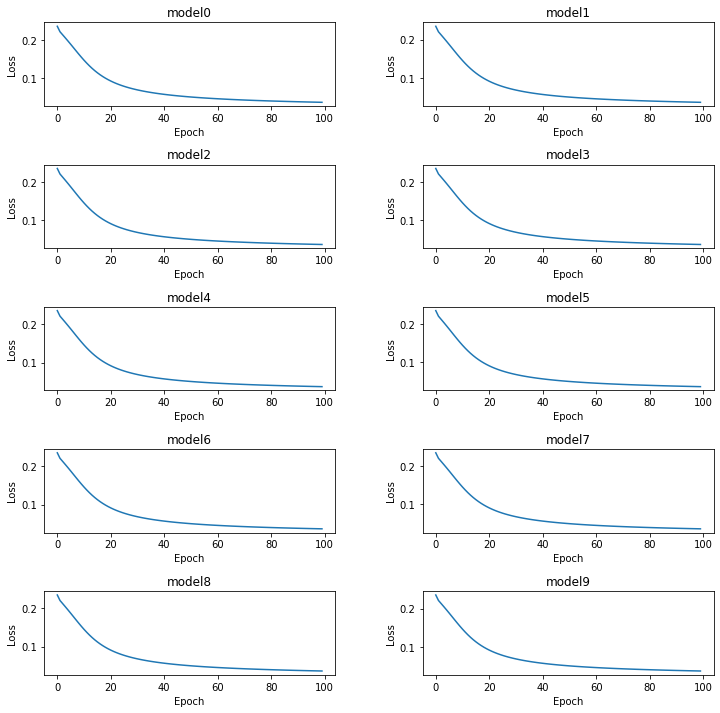

In [8]:
n_cols=2
n_rows=int(number_of_nodes/n_cols)
# Creating 2x2 plot area
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.7)
for ax,(name, value) in zip(axes.reshape(-1), model_costs.items()):
  ax.plot(value)
  ax.set(xlabel='Epoch', ylabel='Loss', title=name)


plt.show()